In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# 훈련용 데이터와 테스트용 데이터를 불러옵니다.
# '\t'는 데이터가 탭(tab)으로 구분되어 있다는 의미입니다.
train_df = pd.read_csv('./review_dataset/ratings_train.txt', sep='\t')
test_df = pd.read_csv('./review_dataset/ratings_test.txt', sep='\t')


In [4]:
# 데이터가 어떻게 생겼는지 상위 5개만 출력해봅니다.
print(train_df.head())


         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [5]:
# 훈련용 데이터의 전체적인 정보를 확인합니다.
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None


In [6]:
# 긍정(1) 리뷰와 부정(0) 리뷰가 각각 몇 개인지 확인합니다.
print(train_df['label'].value_counts())


label
0    75173
1    74827
Name: count, dtype: int64


In [7]:
# 1. 결측치 확인: 'document' 열에 비어있는 값이 있는지 확인합니다.
print('결측치 확인 전:', train_df.isnull().sum())
print('결측치 확인 전:', test_df.isnull().sum())

# 2. 결측치 제거: 비어있는 행(row)을 제거합니다.
train_df = train_df.dropna(subset=['document'])
test_df = test_df.dropna(subset=['document'])
print('결측치 확인 후:', train_df.isnull().sum())
print('결측치 확인 후:', test_df.isnull().sum())

# 3. 중복 데이터 확인: 중복된 리뷰가 있는지 확인합니다.
print('중복 데이터 개수:', train_df['document'].nunique(), '/', len(train_df))
print('중복 데이터 개수:', test_df['document'].nunique(), '/', len(test_df))

# 4. 중복 데이터 제거: 중복된 리뷰를 제거합니다.
train_df.drop_duplicates(subset=['document'], inplace=True)
print('중복 제거 후 개수:', len(train_df))
test_df.drop_duplicates(subset=['document'], inplace=True)
print('중복 제거 후 개수:', len(test_df))


결측치 확인 전: id          0
document    5
label       0
dtype: int64
결측치 확인 전: id          0
document    3
label       0
dtype: int64
결측치 확인 후: id          0
document    0
label       0
dtype: int64
결측치 확인 후: id          0
document    0
label       0
dtype: int64
중복 데이터 개수: 146182 / 149995
중복 데이터 개수: 49157 / 49997
중복 제거 후 개수: 146182
중복 제거 후 개수: 49157


In [7]:
# 각 리뷰의 길이를 계산해서 새로운 'length' 열을 추가합니다.
train_df['length'] = train_df['document'].apply(len)

# 리뷰 길이의 통계 정보를 확인합니다. (평균, 표준편차, 최대/최소 등)
print(train_df['length'].describe())


count    146182.000000
mean         35.981338
std          29.491233
min           1.000000
25%          16.000000
50%          27.000000
75%          43.000000
max         146.000000
Name: length, dtype: float64


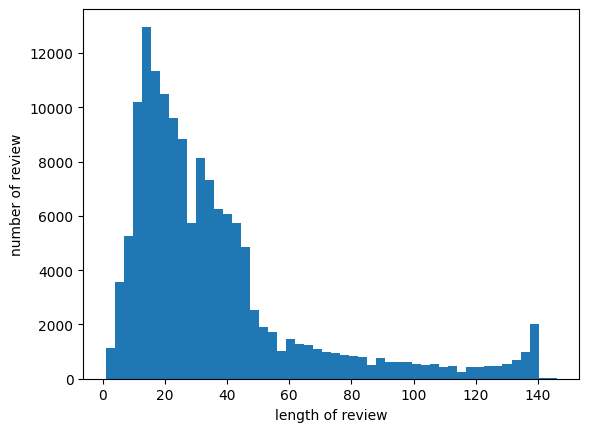

In [8]:
# 리뷰 길이 분포를 히스토그램으로 시각화합니다.
plt.hist(train_df['length'], bins=50)
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

In [9]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib  # scikit-learn 객체를 저장하기 위한 라이브러리
from scipy.sparse import save_npz, load_npz # 희소 행렬을 저장하기 위한 라이브러리

# Okt 객체 생성 (형태소 분석기)
okt = Okt()

def okt_tokenizer(text):
    # 형태소 단위로 나누고, 어간을 추출합니다.
    return okt.morphs(text, stem=True)

# TF-IDF 벡터화 객체 생성
tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1, 2), min_df=3, max_df=0.9)

# train_df의 'document' 열을 TF-IDF 행렬로 변환
tfidf.fit(train_df['document'])
X_train = tfidf.transform(train_df['document'])
X_test = tfidf.transform(test_df['document'])

# 정답 데이터(label) 준비
y_train = train_df['label']
y_test = test_df['label']

/home/asd/rec_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
# --- 3. 결과물 파일로 저장하기 ---
joblib.dump(tfidf, './review_dataset/tfidf_vectorizer.pkl')

# 변환된 데이터(숫자 행렬)를 저장
save_npz('./review_dataset/X_train_tfidf.npz', X_train)
save_npz('./review_dataset/X_test_tfidf.npz', X_test)

# 정답 데이터도 함께 저장 (데이터-정답 짝을 맞추기 위함)
y_train.to_csv('./review_dataset/y_train.csv', index=False)
y_test.to_csv('./review_dataset/y_test.csv', index=False)

print("모든 전처리 결과가 파일로 저장되었습니다.")

모든 전처리 결과가 파일로 저장되었습니다.


In [11]:
import joblib
from scipy.sparse import load_npz
import pandas as pd
from konlpy.tag import Okt

okt = Okt()
def okt_tokenizer(text):
    return okt.morphs(text, stem=True)

# --- 저장된 전처리 결과물 불러오기 ---

# TfidfVectorizer 객체를 불러오기
tfidf = joblib.load('./review_dataset/tfidf_vectorizer.pkl')

# 변환된 데이터(숫자 행렬)를 불러오기
X_train = load_npz('./review_dataset/X_train_tfidf.npz')
X_test = load_npz('./review_dataset/X_test_tfidf.npz')

# 정답 데이터를 불러오기
y_train = pd.read_csv('./review_dataset/y_train.csv')['label']
y_test = pd.read_csv('./review_dataset/y_test.csv')['label']

print(" 저장된 전처리 파일을 성공적으로 불러왔습니다.")


 저장된 전처리 파일을 성공적으로 불러왔습니다.


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 로지스틱 회귀 모델 생성 및 학습
lr_model = LogisticRegression(random_state=0, C=3.5, max_iter=1000)
lr_model.fit(X_train, y_train)

# 테스트 데이터로 예측 및 정확도 평가
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f" Baseline 모델 정확도: {accuracy*100:.2f}%")

 Baseline 모델 정확도: 86.75%


In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 사용할 모델의 이름을 지정합니다. (kcELECTRA는 한국어 데이터로 잘 학습된 모델 중 하나입니다)
MODEL_NAME = "beomi/kcELECTRA-base-v2022"

# 모델 이름에 맞는 토크나이저와 모델을 불러옵니다.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # 긍정/부정 2개로 분류

/home/asd/rec_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-14 14:15:23.904702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-14 14:15:23.904796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-14 14:15:23.955106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-14 14:15:24.056351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimiz

In [14]:
# 예시 문장
text = "이 영화 정말 재밌네요!"

# 토크나이저로 문장을 인코딩합니다.
inputs = tokenizer.encode_plus(
    text,
    None,
    add_special_tokens=True, # [CLS], [SEP] 같은 특수 토큰 추가
    max_length=20,           # 최대 길이를 20으로 설정
    padding='max_length',    # max_length에 맞춰 나머지를 0으로 채움(패딩)
    truncation=True,         # max_length를 넘는 부분은 잘라냄
    return_tensors='pt'      # PyTorch 텐서로 반환
)

# 결과 확인
print('입력 ID:', inputs['input_ids'])
print('어텐션 마스크:', inputs['attention_mask'])

입력 ID: tensor([[    2,  2700,  9556,  8023, 12386,  7985,     5,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
어텐션 마스크: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [15]:
from torch.utils.data import Dataset
import torch

class NSMCDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        # 1. 행(row)에서 리뷰 텍스트와 라벨을 가져옵니다.
        review = str(self.data.iloc[index]['document'])
        label = self.data.iloc[index]['label']
        
        # 2. 텍스트를 토큰화합니다.
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # 3. 필요한 정보들을 딕셔너리 형태로 반환합니다.
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [16]:
from torch.utils.data import DataLoader

# 1. 하이퍼파라미터(Hyperparameter)로 MAX_LEN 값을 정의합니다.

MAX_LEN = 128 
BATCH_SIZE = 16 # 배치 사이즈도 여기서 함께 정의하면 좋습니다.

# 2. Dataset 객체를 생성할 때 max_len 인자로 전달합니다.
train_dataset = NSMCDataset(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = NSMCDataset(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# 3. 생성된 Dataset으로 DataLoader를 만듭니다.
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [17]:
# 4. 데이터가 잘 만들어졌는지 하나 꺼내서 확인해볼 수 있습니다.
data = next(iter(train_dataloader))
print(data['input_ids'].shape) # 결과: torch.Size([16, 128]) -> (배치사이즈, max_len

torch.Size([16, 128])


In [20]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

# GPU 장치 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# 옵티마이저 설정
# AdamW는 트랜스포머 모델 튜닝에 효과적인 옵티마이저입니다.
optimizer = AdamW(
    model.parameters(),
    lr=2e-5, # 학습률 (learning rate)
)

# 학습 에폭(epoch) 수
N_EPOCHS = 3

# 전체 학습 스텝 수 계산
total_steps = len(train_dataloader) * N_EPOCHS

# 학습률을 점진적으로 감소시키는 스케줄러 설정
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 손실 함수 정의
loss_fn = nn.CrossEntropyLoss().to(device)

In [21]:
# 1 에폭 동안 모델을 학습시키는 함수
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train() # 모델을 학습 모드로 설정
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        # 모델 출력 계산
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # 정확도 계산
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        
        # 손실(loss) 계산
        loss = loss_fn(outputs.logits, labels)
        losses.append(loss.item())
        
        # 역전파
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# 모델의 성능을 평가하는 함수
def eval_model(model, data_loader, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정
    losses = []
    correct_predictions = 0
    
    with torch.no_grad(): # 기울기 계산 비활성화
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            
            loss = loss_fn(outputs.logits, labels)
            losses.append(loss.item())
            
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [22]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(N_EPOCHS):
    print(f'Epoch {epoch + 1}/{N_EPOCHS}')
    print('-' * 10)
    
    # 훈련
    train_acc, train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
    
    # 평가
    val_acc, val_loss = eval_model(
        model,
        test_dataloader, # test_dataloader를 검증용으로 사용
        loss_fn,
        device
    )
    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')
    print()
    
    # 기록
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # 가장 성능이 좋은 모델 저장
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

print(f"최고 검증 정확도: {best_accuracy:.4f}")

Epoch 1/3
----------
Train loss 0.2279 accuracy 0.9085
Val   loss 0.1965 accuracy 0.9226

Epoch 2/3
----------
Train loss 0.1414 accuracy 0.9476
Val   loss 0.2053 accuracy 0.9250

Epoch 3/3
----------
Train loss 0.0829 accuracy 0.9715
Val   loss 0.2454 accuracy 0.9257

최고 검증 정확도: 0.9257
